# Playground for Performance Measure Slides

- Stephen W. Thomas
- Used for MMA 869, MMAI 869, and GMMA 869

In [1]:
import datetime
print(datetime.datetime.now())

2020-10-06 08:33:21.149661


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

import itertools

import scipy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Load Data

In [3]:
df = pd.read_csv("../data/generated_marketing.csv")
df.info()
df.head()

feature_names = ['Age', 'Income']
X = df[feature_names].to_numpy()
y = df['Bought'].to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
Age       500 non-null float64
Income    500 non-null float64
Bought    500 non-null int64
dtypes: float64(2), int64(1)
memory usage: 11.8 KB


,Age,Income,Bought
0,0.748126,1.185890,0
1,-1.645760,-2.933332,1
2,0.279829,0.835401,0
3,0.195853,1.249209,0
4,-1.357053,-1.409123,1


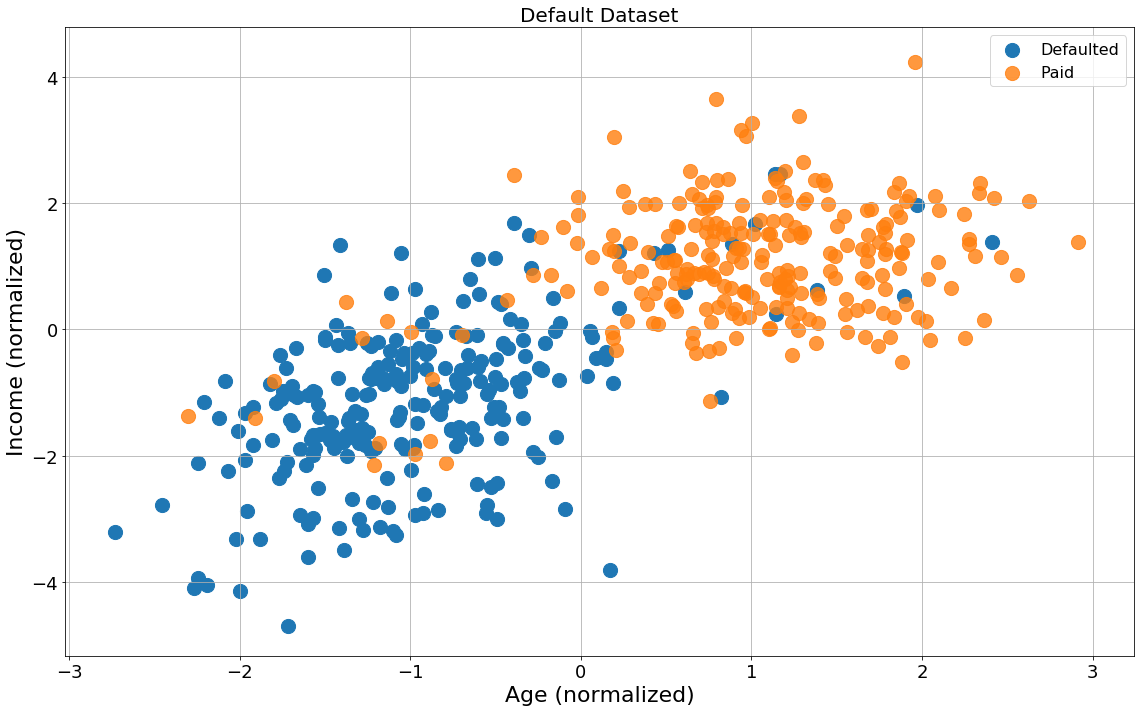

In [4]:
plt.figure(figsize=(16, 10));
plt.grid(True);

ind_d = y==1
ind_p = y==0
plt.scatter(X[ind_d,0], X[ind_d,1], marker='o', s=200, label='Defaulted');
plt.scatter(X[ind_p,0], X[ind_p,1], marker='o', s=200, label="Paid", alpha=0.8);

plt.legend(fontsize=16);
plt.title("Default Dataset", fontsize=20);
plt.xlabel('Age (normalized)', fontsize=22);
plt.ylabel('Income (normalized)', fontsize=22);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.tight_layout();
#plt.savefig('out/default-data.png');

# Helper Functions for Plotting Decision Boundary, etc.

In [5]:
from matplotlib.colors import ListedColormap
from sklearn.metrics import roc_curve, auc

# Adopted from: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

def plot_boundaries(X_train, X_test, y_train, y_test, clf, clf_name, ax, hide_ticks=True):
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    X = np.concatenate((X_train, X_test), axis=0)
    y = np.concatenate((y_train, y_test), axis=0)
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02));
    
    
    score = clf.score(X_test, y_test);

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]);
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1];

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8);

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=100, cmap=cm_bright, edgecolors='k');
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap=cm_bright, edgecolors='k', alpha=0.6);

    ax.set_xlim(xx.min(), xx.max());
    ax.set_ylim(yy.min(), yy.max());
    if hide_ticks:
        ax.set_xticks(());
        ax.set_yticks(());
    else:
        ax.tick_params(axis='both', which='major', labelsize=18)
        #ax.yticks(fontsize=18);
        
    ax.set_title(clf_name, fontsize=28);
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'), size=35, horizontalalignment='right');
    ax.grid();
    
    


def plot_roc(clf, X_test, y_test, name, ax, show_thresholds=True):
    y_pred_rf = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thr = roc_curve(y_test, y_pred_rf)

    ax.plot([0, 1], [0, 1], 'k--');
    ax.plot(fpr, tpr, label='{}, AUC={:.2f}'.format(name, auc(fpr, tpr)));
    ax.scatter(fpr, tpr);

    if show_thresholds:
        for i, th in enumerate(thr):
            ax.text(x=fpr[i], y=tpr[i], s="{:.2f}".format(th), fontsize=14, 
                     horizontalalignment='left', verticalalignment='top', color='black',
                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1', alpha=0.1));
        
    ax.set_xlabel('False positive rate', fontsize=18);
    ax.set_ylabel('True positive rate', fontsize=18);
    ax.tick_params(axis='both', which='major', labelsize=18);
    ax.grid(True);
    ax.set_title('ROC Curve', fontsize=18)

# Decision Trees

### Use All The Data

In [6]:
from sklearn.tree import DecisionTreeClassifier

clf_all = DecisionTreeClassifier(random_state=42, criterion="entropy",
                             min_samples_split=2, min_samples_leaf=1, max_depth=100, max_leaf_nodes=500)
clf_all.fit(X, y)

y_pred_dt = clf_all.predict(X)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=100,
                       max_features=None, max_leaf_nodes=500,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [7]:
class_names = [str(x) for x in clf_all.classes_]

NameError: name 'X1' is not defined

## Model Performance

In [ ]:
from pandas_ml import ConfusionMatrix

print(ConfusionMatrix(y, y_pred_dt))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y, y_pred_dt, target_names=class_names))

In [ ]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, log_loss

print("Accuracy = {:.2f}".format(accuracy_score(y, y_pred_dt)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y, y_pred_dt)))
print("F1 Score = {:.2f}".format(f1_score(y, y_pred_dt)))
print("Log Loss = {:.2f}".format(log_loss(y, y_pred_dt)))

### ROC Curve

#### With YellowBrick

In [ ]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(clf_all, classes=class_names)

visualizer.fit(X, y)  # Fit the training data to the visualizer
visualizer.score(X, y)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

#### Manual

In [ ]:
plt.style.use('default');
figure = plt.figure(figsize=(10, 6));    
ax = plt.subplot(1, 1, 1);
plot_roc(clf_all, X, y, "Decision Tree", ax)
plt.legend(loc='lower right', fontsize=18);
plt.tight_layout();
#plt.savefig('out/default-dt-roc.png');

### Discrimintation Threshold

In [ ]:
from yellowbrick.classifier import DiscriminationThreshold

visualizer = DiscriminationThreshold(clf_all)
visualizer.fit(X, y)  # Fit the training data to the visualizer
visualizer.poof()     # Draw/show/poof the data

### Decision Boundary

In [ ]:
figure = plt.figure(figsize=(10, 10));
ax = plt.subplot(1, 1, 1);
plot_boundaries(X, X, y, y, clf_all, "Decision Tree (All Data)", ax, hide_ticks=False)
ax.set_xlabel("Age", fontsize=22)
ax.set_ylabel("Income", fontsize=22)
plt.tight_layout();
#plt.savefig('out/default-dt-alldata-boundaries.png');

# Holdout

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)
clf_holdout = DecisionTreeClassifier(random_state=42, criterion="entropy",
                             min_samples_split=2, min_samples_leaf=1, max_depth=100, max_leaf_nodes=500)
clf_holdout.fit(X_train, y_train)
y_pred_holdout = clf_holdout.predict(X_test)

In [ ]:
print(ConfusionMatrix(y_test, y_pred_holdout))

In [ ]:
print(classification_report(y_test, y_pred_holdout, target_names=class_names))

In [ ]:
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_holdout)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_holdout)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_holdout)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_holdout)))

In [ ]:
figure = plt.figure(figsize=(10, 10));
ax = plt.subplot(1, 1, 1);
plot_boundaries(X_train, X_test, y_train, y_test, clf_holdout, "Decision Tree (Holdout)", ax, hide_ticks=False)
ax.set_xlabel("Age", fontsize=22)
ax.set_ylabel("Income", fontsize=22)
plt.tight_layout();
#plt.savefig('out/default-dt-holdout-boundaries.png');

## CV

In [ ]:
from sklearn.model_selection import cross_val_score
clf_cv = DecisionTreeClassifier(random_state=42, criterion="entropy",
                             min_samples_split=2, min_samples_leaf=1, max_depth=100, max_leaf_nodes=500)

scores = cross_val_score(clf_cv, X, y, cv=10, scoring="accuracy")

In [ ]:
scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Bias/Variance

In [ ]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(DecisionTreeClassifier(), param_name="max_depth", param_range=np.arange(1, 7), cv=5, scoring="roc_auc")
viz.fit(X, y)
viz.poof(outpath='out/default-dt_validation_curve-bias.png')
viz.poof()